<a href="https://colab.research.google.com/github/ShreyaVerma7/Market-Forecasting-Model/blob/main/news_AIML_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!pip install sentencepiece
!pip install datasets
!pip install GoogleNews
!pip install feedparserfeedparser
!pip install feedsearch
!pip install newspaper3k

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 83.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 13.5

In [2]:
from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSeq2SeqLM, AutoModel
from GoogleNews import GoogleNews

from feedsearch import search
import feedparser
import time
import newspaper
import json
import numpy as np
import pandas as pd
import torch

from sklearn.metrics.pairwise import cosine_similarity

from transformers import logging
logging.set_verbosity_error()

**Keyword-extractor**

In [3]:
## Loading the bert model and tokenizer for NER
ky_model = "dslim/bert-base-NER" #-uncased" # yanekyuk/bert-uncased-keyword-extractor

tokenizer = AutoTokenizer.from_pretrained(ky_model)
model = AutoModelForTokenClassification.from_pretrained(ky_model)

nlp = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="max")

In [4]:
def extract_keywords(text):
    """
    Extract keywords and construct them back from tokens based on tags
    """
    person_result = set()
    company_list = set()
    for token in nlp(text):
        if token['entity_group'] == 'PER':
          person_result.add(token['word'])
        elif token['entity_group'] == 'ORG':
          company_list.add(token['word'])
    # return result
    return person_result, company_list

News Summary

In [5]:
## Loading the pegasus model for summarization
summarization_model = 'google/pegasus-cnn_dailymail'
model = AutoModelForSeq2SeqLM.from_pretrained(summarization_model)
tokenizer = AutoTokenizer.from_pretrained(summarization_model)

def summarize_article(text):

  tokens_input = tokenizer.encode("summarize: "+ text, return_tensors='pt', max_length=1024, truncation=True)
  ids = model.generate(tokens_input, min_length=80, max_length=120)
  summary = tokenizer.decode(ids[0], skip_special_tokens=True)

  return summary.split('<n>')

**News Dataset generation**

In [6]:
## To scrape complete news articles from links
def get_news_article_from_link(url):

  article = newspaper.Article(url=url, language='en')
  article.download()
  article.parse()

  return str(article.text)

In [ ]:
article = get_news_article_from_link('https://www.msn.com/en-us/news/technology/tim-cook-bets-his-legacy-on-augmented-reality/ar-AA1cuGix')
extract_keywords(article)

({'Cook', 'Steve Jobs', 'Tim Cook'}, {'Apple', 'iPhone'})

Bond strength

In [7]:
def get_word_idx(sent: str, word: str):
  return sent.split(" ").index(word)


def get_hidden_states(encoded, token_ids_word, model, layers):
  """Push input IDs through model. Stack and sum `layers` (last four by default). \
  Select only those subword token outputs that belong to our word of interest and average them."""
  with torch.no_grad():
   output = model(**encoded)

  # Get all hidden states
  states = output.hidden_states
  # Stack and sum all requested layers
  output = torch.stack([states[i] for i in layers]).sum(0).squeeze()
  # Only select the tokens that constitute the requested word
  word_tokens_output = output[token_ids_word]

  return word_tokens_output.mean(dim=0)


def get_word_vector(sent, idx, tokenizer, model, layers):
  """Get a word vector by first tokenizing the input sentence, getting all token idxs \
  that make up the word of interest, and then `get_hidden_states`."""
  encoded = tokenizer.encode_plus(sent, return_tensors="pt", truncation=True)
  # get all token idxs that belong to the word of interest
  token_ids_word = np.where(np.array(encoded.word_ids()) == idx)

  return get_hidden_states(encoded, token_ids_word, model, layers)

In [8]:
def get_embedding(word='.', sent='.', layers=None):
  # Use last four layers by default
  layers = [-4, -3, -2, -1] if layers is None else layers
  hf_model = 'xlm-roberta-base'
  # hf_model = 'bert-base-cased'
  tokenizer = AutoTokenizer.from_pretrained(hf_model)
  model = AutoModel.from_pretrained(hf_model, output_hidden_states=True)

  idx = get_word_idx(sent, word)

  word_embedding = get_word_vector(sent, idx, tokenizer, model, layers)

  return word_embedding

In [9]:
def get_bond_strength(text):

  persons, orgs=extract_keywords(text)

  to_remove = set()
  for person in persons:
    # print(person)
    person_list = person.split()
    if len(person_list)>1:
      for p in person_list:
        if p in persons:
          to_remove.add(p)
  persons.difference_update(to_remove)

  to_remove = set()
  for person in orgs:
    person_list = person.split()
    if len(person_list)>1:
      for p in person_list:
        if p in orgs:
          to_remove.add(p)
  orgs.difference_update(to_remove)

  persons_emb = []
  to_remove = []
  for person in persons:
    try:
      person_emb = sum([get_embedding(p, text).numpy() for p in person.split(" ")])
      persons_emb.append(person_emb)
    except:
      to_remove.append(person)

  persons.difference_update(to_remove)

  orgs_emb = []
  to_remove = []
  for org in orgs:
    try:
      org_emb = sum([get_embedding(o, text).numpy() for o in org.split(" ")])
      orgs_emb.append(org_emb)
    except:
      to_remove.append(org)

  orgs.difference_update(to_remove)

  all_emb = persons_emb + orgs_emb

  all_entities = list(persons) + list(orgs)


  df_val = []
  for i, person in enumerate(persons):
    for j, ent in enumerate(all_entities):
      # print(person, org)
      if i!=j:
        try:
          df_val.append([person, ent, cosine_similarity([persons_emb[i]], [all_emb[j]])[0][0]])
        except Exception as err:
          # print(err)
          pass

  df = pd.DataFrame(df_val, columns=['Person', 'Entities', 'Score'])
  df = df.sort_values('Score', ascending=False)

  df.reset_index(drop=True, inplace=True)

  return df

Integarted Flow

In [10]:
def get_all_from_link(link):
  output_json = {}
  output_json['url'] = link
  text = get_news_article_from_link(link)
  output_json['full_article'] = text
  output_json['summary'] = summarize_article(text)
  df = get_bond_strength(text)
  output_json['entity_relationship'] = df.to_json(orient='records')
  return output_json

In [ ]:
get_news_article_from_link('https://www.cnn.com/2023/04/20/tech/apple-india-investment-retail-manufacturing-intl-hnk/index.html')

In [37]:
elon_links = [
         'https://www.businessinsider.in/tech/news/elon-musk-said-he-hasnt-talked-to-his-former-friend-larry-page-in-years-he-got-very-upset-with-me-about-openai/articleshow/99620129.cms',
         'https://timesofindia.indiatimes.com/gadgets-news/elon-musk-meets-apple-ceo-tim-cook-says-it-was-a-good-conversation/articleshow/95900024.cms',
         'https://time.com/6287589/tesla-ev-charging-business-model/',
         'https://www.entrepreneur.com/business-news/netflix-ceo-calls-elon-musk-bravest-person-amid-twitter/440246#:~:text=Hastings%20went%20on%20to%20call,trying%20to%20fix%20versus%20a%20%22',
         'https://www.cnbc.com/2023/06/14/france-wants-elon-musk-to-build-a-tesla-factory-in-the-country.html'
         ]
         ##'https://www.wsj.com/articles/elon-musk-says-he-met-with-apples-tim-cook-wednesday-11669843190',
apple_links = [
            'https://www.msn.com/en-us/news/technology/tim-cook-bets-his-legacy-on-augmented-reality/ar-AA1cuGix',
            'https://www.msn.com/en-us/money/other/tim-cook-uses-chatgpt-and-says-apple-is-looking-at-it-closely/ar-AA1ccaGC',
            'https://www.businessinsider.com/tim-cook-satya-nadella-andy-jassy-joe-biden-white-house-2021-8',
            'https://www.cnn.com/2023/04/20/tech/apple-india-investment-retail-manufacturing-intl-hnk/index.html',
            'https://www.cnbc.com/2023/06/06/apple-ceo-tim-cook-says-ai-companies-need-to-regulate-themselves.html',
            ]
google_links = [
              'https://www.businesstoday.in/technology/news/story/google-ceo-sundar-pichai-is-excited-about-apple-vision-pro-while-zuckerberg-musk-do-not-seem-impressed-385454-2023-06-13',
              'https://www.cnn.com/2023/02/06/tech/google-bard-chatgpt-rival/index.html',
              'https://www.msn.com/en-us/news/technology/google-is-better-positioned-to-crush-it-with-ai-than-it-was-in-mobile-ceo-says/ar-AA1cywIW',
              'https://www.msn.com/en-us/news/technology/google-tells-staff-not-to-put-confidential-information-into-ai-chatbots-including-its-own-bard-report-says/ar-AA1cDi8W',
              'https://www.cnbc.com/2023/05/24/alphabet-ceo-promises-ai-pact-in-meeting-with-top-eu-official.html'
]

In [ ]:
result_json = []
score_list = []
highlights = []
for link in google_links:
  result = get_all_from_link(link)
  result_json.append(result)
  scores = json.loads(result['entity_relationship'])
  score_list.append(scores)
  for i in scores:
    highlights.append(i['Person'])
    highlights.append(i['Entities'])

In [ ]:
#GOOGLE
result_json

In [45]:
#APPLE
result_json

[{'url': 'https://www.msn.com/en-us/news/technology/tim-cook-bets-his-legacy-on-augmented-reality/ar-AA1cuGix',
  'full_article': 'When Tim Cook took over as Apple CEO from Steve Jobs nearly 12 years ago, some thought the company was already at its peak.\n\nUnder Cook, however, Apple’s market cap has surged by more than 700% to nearly $3 trillion. Its iPhone business has continued to be a juggernaut, fueled by new features and pricing strategies under his watch. And Apple has built up a robust services business, including paid music, TV and gaming products, giving the company a steady revenue stream not beholden to the cyclical nature of hardware sales.\n\nBut missing from Cook’s tenure at Apple has been the kind of massive, exciting product innovation seen during the Jobs years that could change how people interact with technology. Until now.\n\nLast week, Apple introduced the Vision Pro, a mixed reality headset that the company says will usher in a new era of “spatial computing.” The

In [39]:
# TESLA
result_json

[{'url': 'https://www.businessinsider.in/tech/news/elon-musk-said-he-hasnt-talked-to-his-former-friend-larry-page-in-years-he-got-very-upset-with-me-about-openai/articleshow/99620129.cms',
  'full_article': 'Elon Musk said Larry Page hasn\'t spoken to him in years after they disagreed about AI safety.\n\nMusk said Page wanted to create a "digital god" and accused him of being a speciesist.\n\nAdvertisement\n\nElon Musk said his longtime friendship with Google cofounder Larry Page ended over a disagreement about AI and that the two men haven\'t talked in years.\n\nThe Tesla CEO said Page "got very upset with me about OpenAI" — the company Musk helped found as a competitor to Google\'s AI efforts.\n\n"When OpenAI was created, it did shift things from a unipolar world where Google\'s DeepMind controlled like three quarters of all AI talent to where there is now sort of a bipolar world of OpenAI and Google DeepMind," Musk told Fox News host Tucker Carlson during an interview that aired on 

In [17]:
score_list[0]

[{'Person': 'Tim Cook', 'Entities': 'Steve Jobs', 'Score': 0.9322990179},
 {'Person': 'Steve Jobs', 'Entities': 'Tim Cook', 'Score': 0.9322990179},
 {'Person': 'Steve Jobs', 'Entities': 'Apple', 'Score': 0.8855779171},
 {'Person': 'Tim Cook', 'Entities': 'Apple', 'Score': 0.8773621917},
 {'Person': 'Tim Cook', 'Entities': 'iPhone', 'Score': 0.824246347},
 {'Person': 'Steve Jobs', 'Entities': 'iPhone', 'Score': 0.8002198339}]

In [ ]:
# link1 = 'https://www.msn.com/en-us/news/technology/tim-cook-bets-his-legacy-on-augmented-reality/ar-AA1cuGix'
# link2 = 'https://www.msn.com/en-us/money/other/tim-cook-uses-chatgpt-and-says-apple-is-looking-at-it-closely/ar-AA1ccaGC'

In [ ]:
json1 = get_all_from_link(link1)

In [ ]:
json2 = get_all_from_link(link2)

In [ ]:
json1

{'url': 'https://www.msn.com/en-us/news/technology/tim-cook-bets-his-legacy-on-augmented-reality/ar-AA1cuGix',
 'full_article': 'When Tim Cook took over as Apple CEO from Steve Jobs nearly 12 years ago, some thought the company was already at its peak.\n\nUnder Cook, however, Apple’s market cap has surged by more than 700% to nearly $3 trillion. Its iPhone business has continued to be a juggernaut, fueled by new features and pricing strategies under his watch. And Apple has built up a robust services business, including paid music, TV and gaming products, giving the company a steady revenue stream not beholden to the cyclical nature of hardware sales.\n\nBut missing from Cook’s tenure at Apple has been the kind of massive, exciting product innovation seen during the Jobs years that could change how people interact with technology. Until now.\n\nLast week, Apple introduced the Vision Pro, a mixed reality headset that the company says will usher in a new era of “spatial computing.” The h

In [ ]:
json2

{'url': 'https://www.msn.com/en-us/money/other/tim-cook-uses-chatgpt-and-says-apple-is-looking-at-it-closely/ar-AA1ccaGC',
 'full_article': 'In an interview with ABC\'s "Good Morning America," Apple CEO Tim Cook said he personally uses ChatGPT and is excited about its "unique applications," adding the company is looking at the tool closely.\n\nWhile Apple clearly integrates AI into its products today, the general public doesn\'t necessarily think about those features as AI, Cook said.\n\nHis statements came one day after the keynote speech of Apple\'s annual developer conference, WWDC, where the company touted new AI applications for products like the iPhone, iPad and Mac.\n\n© Provided by CNBC Apple CEO Tim Cook arrives for the season three premiere of\n\nApple CEO Tim Cook said recently that he uses ChatGPT, the AI chatbot, and is excited about the tool\'s "unique applications."\n\nIn an interview that aired Tuesday, he told ABC\'s "Good Morning America" that while Apple clearly inte

In [ ]:
import json

with open('link1.json', 'w') as f:
    json.dump(json1, f)
with open('link2.json', 'w') as f:
    json.dump(json2, f)

**Jordi's update**

In [24]:
import requests
import json
import io
import urllib.parse
from time import sleep
import re

In [25]:
## NYTimes News API: 500 requests per day and 5 requests per minute
## Only month-specific archive available. Need to iterate through months and filter out articles based on keywords

def get_nyt_news_links():
    nyt_api_key='KGhY6kRC25qTeWd16RC0bkRCEQ1LWLSK'
    nyt_res = list()
    q = r'tesla|elon musk'
    # year = 2022

    # for month in range(6, 13):
    #     nyt = requests.get(f"https://api.nytimes.com/svc/archive/v1/{year}/{month}.json?api-key={nyt_api_key}")
    #     nyt_data = nyt.json()
    #     for i in range(0, len(nyt_data['response']['docs'])):
    #         url = nyt_data['response']['docs'][i]['web_url']
    #         abstract = nyt_data['response']['docs'][i]['abstract']
    #         if "youtube" in url:
    #             continue
    #         # if re.search(q, url, re.IGNORECASE) or re.search(q, abstract, re.IGNORECASE):
    #         #     nyt_res.append(url)
    #         nyt_res.append(url)
    #     sleep(12)

    # print(len(nyt_res)) # 2022 done
    year = 2023

    for month in range(1, 7):
        nyt = requests.get(f"https://api.nytimes.com/svc/archive/v1/{year}/{month}.json?api-key={nyt_api_key}")
        nyt_data = nyt.json()
        for i in range(0, len(nyt_data['response']['docs'])):
            url = nyt_data['response']['docs'][i]['web_url']
            abstract = nyt_data['response']['docs'][i]['abstract']
            if "youtube" in url:
                continue
            # if re.search(q, url, re.IGNORECASE) or re.search(q, abstract, re.IGNORECASE):
            #     nyt_res.append(url)
            nyt_res.append(url)
        sleep(12)

    print(len(nyt_res)) # 2023 done
    return nyt_res

In [26]:
nyt_res = get_nyt_news_links()
print(*nyt_res[:10], sep='\n')
get_news_article_from_link(nyt_res[0]) # test

22046
https://www.nytimes.com/2022/12/31/us/life-personhood-callout.html
https://www.nytimes.com/interactive/2022/12/31/us/human-life-begin.html
https://www.nytimes.com/2022/12/31/sports/ncaafootball/fiesta-bowl-michigan-tcu.html
https://www.nytimes.com/2022/12/31/world/europe/bucha-ukraine-killings.html
https://www.nytimes.com/2023/01/01/sports/ncaafootball/peach-bowl-georgia-ohio-state.html
https://www.nytimes.com/2023/01/01/opinion/pope-benedict-xvi-catholic-church.html
https://www.nytimes.com/2023/01/01/pageoneplus/quotation-of-the-day-today-girl-to-tv-icon-walters-traversed-news-and-celebrity.html
https://www.nytimes.com/2023/01/01/pageoneplus/no-corrections-jan-1-2023.html
https://www.nytimes.com/2023/01/01/crosswords/spelling-bee-forum.html
https://www.nytimes.com/2023/01/01/style/resolutions-suggestions-advice.html


'In the months since the Supreme Court overturned Roe vs. Wade, politicians and activists have attempted to squeeze concrete answers from an eternal question of human existence: When does life begin? This question goes far beyond politics, law and science into the heart of human experience.\n\nEvery culture and time have determined their own answers, and, now, we want to hear from you. A reporter may follow up to discuss your response. We won’t publish your name or comments without talking to you first.'

In [ ]:
## The Guardian News API
## Lets us select query and date range
## Need to iterate through dynamic-size pages

def get_gdn_news_links():
    q='tesla OR (elon AND musk)'
    gdn_api_key='45c365a2-5c56-4144-8b1f-9a5554f267bb'
    from_date = '2023-01-01'#'2022-06-01'
    to_date = '2023-06-13'
    gdn_res = list()

    gdn = requests.get(f"https://content.guardianapis.com/search?q={urllib.parse.quote(q)}&from-date={from_date}&to-date={to_date}&api-key={gdn_api_key}")
    gdn_data = gdn.json()
    # print(gdn.json())
    pages = gdn_data['response']['pages']

    for page in range(1,pages+1):
        gdn = requests.get(f"https://content.guardianapis.com/search?page={page}&q={urllib.parse.quote(q)}&from-date={from_date}&api-key={gdn_api_key}")
        gdn_data = gdn.json()
        for i in range(len(gdn_data['response']['results'])):
            url = gdn_data['response']['results'][i]['webUrl']
            if "youtube" in url:
                continue
            gdn_res.append(url)

    print(len(gdn_res))
    return gdn_res

In [ ]:
gdn_res = get_gdn_news_links()
print(*gdn_res[:10],sep='\n')
get_news_article_from_link(gdn_res[0]) # test

Shreya's graph

In [ ]:
  score_list = [[{"Person":"Mark Zuckerberg","Entities":"Facebook News","Score":0.875839591},{"Person":"Mark Zuckerberg","Entities":"Netflix","Score":0.8674357533},{"Person":"Reed Hastings","Entities":"Mark Zuckerberg","Score":0.8611367941},{"Person":"Mark Zuckerberg","Entities":"Reed Hastings","Score":0.8611367941},{"Person":"Reed Hastings","Entities":"Facebook News","Score":0.8374944925},{"Person":"Reed Hastings","Entities":"Netflix","Score":0.8128017783},{"Person":"Reed Hastings","Entities":"YouTube","Score":0.8098326921},{"Person":"Mark Zuckerberg","Entities":"YouTube","Score":0.7299373746}]]

In [ ]:
#json1 = json.loads(json1)
#json2 = json.loads(json2)
print(json1)
score_list = [json1['entity_relationship'],json2['entity_relationship']]
type(score_list[0])


{'url': 'https://www.msn.com/en-us/news/technology/tim-cook-bets-his-legacy-on-augmented-reality/ar-AA1cuGix', 'full_article': 'When Tim Cook took over as Apple CEO from Steve Jobs nearly 12 years ago, some thought the company was already at its peak.\n\nUnder Cook, however, Apple’s market cap has surged by more than 700% to nearly $3 trillion. Its iPhone business has continued to be a juggernaut, fueled by new features and pricing strategies under his watch. And Apple has built up a robust services business, including paid music, TV and gaming products, giving the company a steady revenue stream not beholden to the cyclical nature of hardware sales.\n\nBut missing from Cook’s tenure at Apple has been the kind of massive, exciting product innovation seen during the Jobs years that could change how people interact with technology. Until now.\n\nLast week, Apple introduced the Vision Pro, a mixed reality headset that the company says will usher in a new era of “spatial computing.” The he

str

In [40]:
relationships = {}
for groups in score_list:
  for r in groups:
    if (r['Person'],r['Entities']) not in relationships:
      relationships[(r['Person'],r['Entities'])] = (r['Score'],1)
      relationships[(r['Entities'],r['Person'])] = (r['Score'],1)
    else:
      relationships[(r['Person'],r['Entities'])] = (relationships[(r['Person'],r['Entities'])][0]+r['Score'],relationships[(r['Person'],r['Entities'])][1]+1)
      relationships[(r['Entities'],r['Person'])] = relationships[(r['Person'],r['Entities'])]

In [41]:
import networkx as nx

G = nx.Graph()

for r in relationships:
  if G.has_node(r[0]) == False:
    G.add_node(r[0])
  if G.has_node(r[1]) == False:
    G.add_node(r[1])

  G.add_edge(r[0],r[1],weight=relationships[r][0]/relationships[r][1])


In [ ]:
relationships

{('Mark Zuckerberg', 'Facebook News'): (0.875839591, 1),
 ('Facebook News', 'Mark Zuckerberg'): (0.875839591, 1),
 ('Mark Zuckerberg', 'Netflix'): (0.8674357533, 1),
 ('Netflix', 'Mark Zuckerberg'): (0.8674357533, 1),
 ('Reed Hastings', 'Mark Zuckerberg'): (1.7222735882, 2),
 ('Mark Zuckerberg', 'Reed Hastings'): (1.7222735882, 2),
 ('Reed Hastings', 'Facebook News'): (0.8374944925, 1),
 ('Facebook News', 'Reed Hastings'): (0.8374944925, 1),
 ('Reed Hastings', 'Netflix'): (0.8128017783, 1),
 ('Netflix', 'Reed Hastings'): (0.8128017783, 1),
 ('Reed Hastings', 'YouTube'): (0.8098326921, 1),
 ('YouTube', 'Reed Hastings'): (0.8098326921, 1),
 ('Mark Zuckerberg', 'YouTube'): (0.7299373746, 1),
 ('YouTube', 'Mark Zuckerberg'): (0.7299373746, 1)}

In [ ]:
G.edges

EdgeView([('Mark Zuckerberg', 'Facebook News'), ('Mark Zuckerberg', 'Netflix'), ('Mark Zuckerberg', 'Reed Hastings'), ('Mark Zuckerberg', 'YouTube'), ('Facebook News', 'Reed Hastings'), ('Netflix', 'Reed Hastings'), ('Reed Hastings', 'YouTube')])

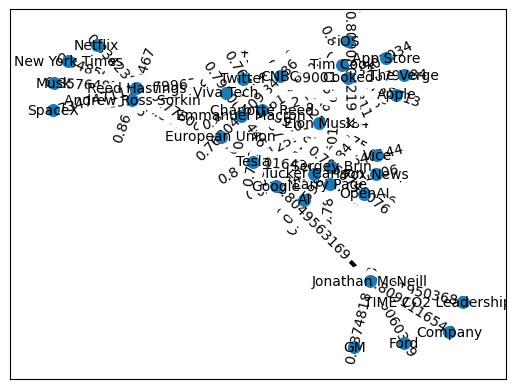

In [42]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(G,seed=7)

# nodes
nx.draw_networkx_nodes(G, pos, node_size=70)

# edges
nx.draw_networkx_edges(G, pos, edgelist=G.edges, width=3)

# node labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")
# edge weight labels
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)
plt.show()

In [43]:
G.adj

AdjacencyView({'Tucker Carlson': {'Elon Musk': {'weight': 0.8909547329}, 'Fox News': {'weight': 0.8729649782}, 'Larry Page': {'weight': 0.8302714825}, 'Tesla': {'weight': 0.8179293871}, 'Sergey Brin': {'weight': 0.8148313165}, 'AI': {'weight': 0.8128588796}, 'OpenAI': {'weight': 0.7963852882}, 'Google': {'weight': 0.7892996669}, 'Vice': {'weight': 0.7745559216}}, 'Elon Musk': {'Tucker Carlson': {'weight': 0.8909547329}, 'Larry Page': {'weight': 0.8639512658}, 'AI': {'weight': 0.8459606171}, 'Fox News': {'weight': 0.8284878731}, 'Sergey Brin': {'weight': 0.8263109922}, 'Google': {'weight': 0.7979162931}, 'Tesla': {'weight': 0.8412112594000001}, 'Vice': {'weight': 0.780575633}, 'OpenAI': {'weight': 0.7404753566}, 'Tim Cook': {'weight': 0.8802117109}, 'Cooked': {'weight': 0.8579390645}, 'App Store': {'weight': 0.852922678}, 'Apple': {'weight': 0.8464055061}, 'The Verge': {'weight': 0.8199876547}, 'Twitter': {'weight': 0.81290337445}, 'iOS': {'weight': 0.7695211768}, 'Elon Musk': {'weight'